In [16]:
from hdfs import InsecureClient
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

client = InsecureClient('http://localhost:9870', user='root')

# Caminho do arquivo no HDFS
file_path = '/datalake/raw/egressos/egressos.csv'

print(f"Lendo arquivo: {file_path}")

# 2. Lê o arquivo e carrega no Pandas
# O 'encoding' é importante para transformar os bytes em string para o Pandas
with client.read(file_path, encoding='utf-8') as reader:
    df = pd.read_csv(reader)

Lendo arquivo: /datalake/raw/egressos/egressos.csv


# 1.  Exploração

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Nome                            202 non-null    object
 1   Profissão                       198 non-null    object
 2   Anos Reclusão                   202 non-null    int64 
 3   Data liberdade                  197 non-null    object
 4   Anos sem trabalho na profissão  202 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 8.0+ KB


In [18]:
df.isnull().sum()

Nome                              0
Profissão                         4
Anos Reclusão                     0
Data liberdade                    5
Anos sem trabalho na profissão    0
dtype: int64

In [19]:
df['Profissão'].unique()

array(['Auxiliar de Logística', 'Operador de Caixa',
       'Atendente de Telemarketing', 'motorista de entrega',
       'Auxiliar Administrativo', 'Estoquista', 'Porteiro',
       'Recepcionista', 'Vendedor de Loja', 'Auxiliar de Produção',
       'Cobrador de Ônibus', 'Operador de Empilhadeira', 'Cozinheiro',
       'Garçom', 'Pedreiro', 'Eletricista', 'Técnico de Manutenção',
       'Segurança', 'Motoboy', 'Repositor de Mercadorias',
       'Auxiliar de limpeza', 'Jardineiro', 'Pintor',
       'Bombeiro Hidráulico', nan, 'operador de caixa',
       'Motorista de Entrega', 'AUXILIAR ADMINISTRATIVO',
       'Técnico de manutenção', 'SEGURANÇA', 'auxiliar administrativo',
       'Seguranca', 'VENDEDOR DE LOJA'], dtype=object)

#2.   Limpeza e Normalização de dados com Python

## Valores ausentes - Removendo Nulos/NaN

In [20]:
df_cleaned = df.dropna()
display(df_cleaned.head())

,Nome,Profissão,Anos Reclusão,Data liberdade,Anos sem trabalho na profissão
0,João Silva,Auxiliar de Logística,8,2025-01-15,9
1,Carlos Santos,Operador de Caixa,5,2024-03-22,5
2,Ana Oliveira,Atendente de Telemarketing,3,2023-11-10,4
3,Pedro Souza,motorista de entrega,7,2024-08-01,9
4,Mariana Ferreira,Auxiliar Administrativo,10,2025-05-30,11


## Renomeando colunas

In [21]:
colunas = {'Nome':'nome', 'Profissão': 'profissao', 'Data liberdade': 'dt_liberdade', 'Anos Reclusão': 'anos_reclusao', 'Anos sem trabalho na profissão': 'anos_fora_oficio'}
df_cleaned.rename(columns=colunas, inplace=True)

/tmp/ipykernel_30571/1686167214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.rename(columns=colunas, inplace=True)


 ## Convertendo campo

In [22]:
df_cleaned.loc[:, 'dt_liberdade'] = pd.to_datetime(df_cleaned['dt_liberdade'])
display(df_cleaned.head())

,nome,profissao,anos_reclusao,dt_liberdade,anos_fora_oficio
0,João Silva,Auxiliar de Logística,8,2025-01-15 00:00:00,9
1,Carlos Santos,Operador de Caixa,5,2024-03-22 00:00:00,5
2,Ana Oliveira,Atendente de Telemarketing,3,2023-11-10 00:00:00,4
3,Pedro Souza,motorista de entrega,7,2024-08-01 00:00:00,9
4,Mariana Ferreira,Auxiliar Administrativo,10,2025-05-30 00:00:00,11


## Normalizando Profissão

In [23]:
from numpy._core.defchararray import lower
import unicodedata

def normnalizar_texto(texto: str):
    # 1. Normaliza para NFD (separa letra do acento)
    # 2. Codifica para ASCII ignorando erros (os acentos soltos somem)
    # 3. Decodifica de volta para string
    # 4. Converte para minúsculo
    # 5. Remove espaços à esquerda e direita
    return unicodedata.normalize('NFD', texto)\
           .encode('ascii', 'ignore')\
           .decode('utf-8')\
           .lower().lstrip().rstrip()

In [24]:
df_cleaned.loc[:, 'profissao'] = df_cleaned.loc[:, 'profissao'].apply(normnalizar_texto)
display(df_cleaned.head())

,nome,profissao,anos_reclusao,dt_liberdade,anos_fora_oficio
0,João Silva,auxiliar de logistica,8,2025-01-15 00:00:00,9
1,Carlos Santos,operador de caixa,5,2024-03-22 00:00:00,5
2,Ana Oliveira,atendente de telemarketing,3,2023-11-10 00:00:00,4
3,Pedro Souza,motorista de entrega,7,2024-08-01 00:00:00,9
4,Mariana Ferreira,auxiliar administrativo,10,2025-05-30 00:00:00,11


#3. Estatística Descritiva

In [25]:
df_cleaned.describe()

,anos_reclusao,anos_fora_oficio
count,193.000000,193.000000
mean,6.937824,7.378238
std,2.869790,2.911354
min,2.000000,2.000000
25%,5.000000,5.000000
50%,7.000000,7.000000
75%,9.000000,9.000000
max,15.000000,15.000000


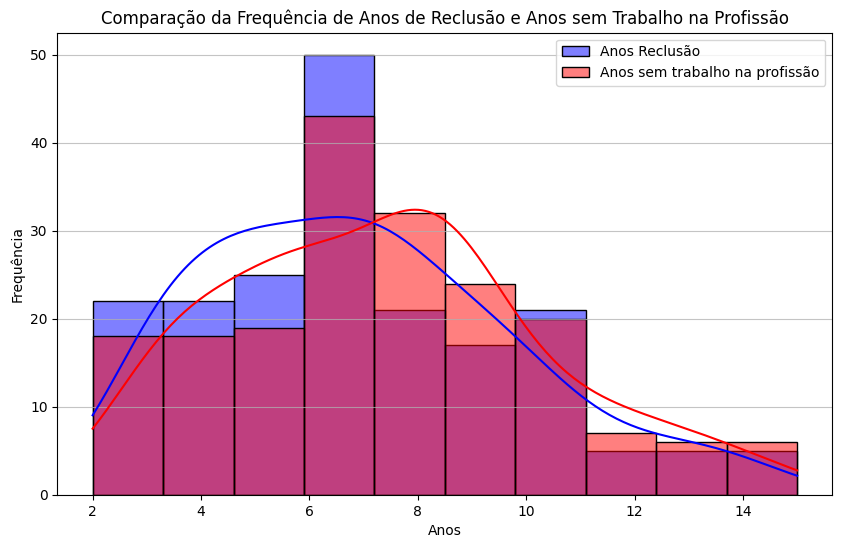

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['anos_reclusao'], color='blue', label='Anos Reclusão', kde=True, alpha=0.5)
sns.histplot(df_cleaned['anos_fora_oficio'], color='red', label='Anos sem trabalho na profissão', kde=True, alpha=0.5)
plt.title('Comparação da Frequência de Anos de Reclusão e Anos sem Trabalho na Profissão')
plt.xlabel('Anos')
plt.ylabel('Frequência')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

#4. Análise de correlação e associação

In [27]:
correlation = df_cleaned['anos_reclusao'].corr(df_cleaned['anos_fora_oficio'])
print(f"A correlação entre 'Anos Reclusão' e 'Anos sem trabalho na profissão' é: {correlation:.2f}")

A correlação entre 'Anos Reclusão' e 'Anos sem trabalho na profissão' é: 0.98


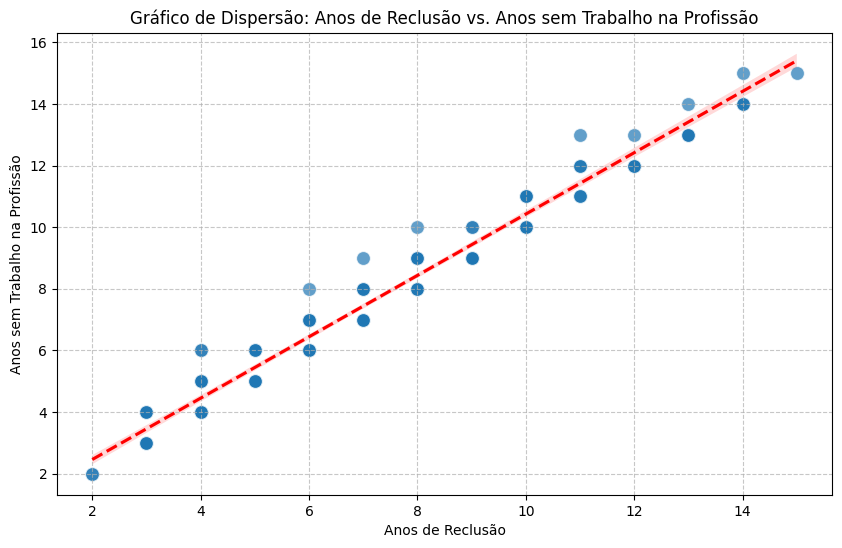

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='anos_reclusao', y='anos_fora_oficio', data=df_cleaned, s=100, alpha=0.7)
sns.regplot(x='anos_reclusao', y='anos_fora_oficio', data=df_cleaned, scatter=False, color='red', line_kws={'linestyle': '--'})
plt.title('Gráfico de Dispersão: Anos de Reclusão vs. Anos sem Trabalho na Profissão')
plt.xlabel('Anos de Reclusão')
plt.ylabel('Anos sem Trabalho na Profissão')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Este gráfico de dispersão mostra a relação entre 'Anos de Reclusão' e 'Anos sem Trabalho na Profissão'. A linha tracejada vermelha é uma linha de regressão, que visualmente representa a tendência da correlação entre as duas variáveis. Quanto mais próximos os pontos estiverem dessa linha e quanto mais a linha se inclinar (positiva ou negativamente), mais forte será a correlação.